In [1]:
import numpy
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.optimize
%matplotlib inline
from numpy import asarray

In [2]:
def uniquify(seq, idfun=None): 
   # order preserving
    if idfun is None:
        def idfun(x): return x
    seen = {}
    result = []
    for item in seq:
        marker = idfun(item)
        # in old Python versions:
        # if seen.has_key(marker)
        # but in new ones:
        if marker in seen: continue
        seen[marker] = 1
        result.append(item)
    return result

# Data

In [3]:
# t1 is for Cx and t2 is for rCO2 (both are in hours)
t1 = [1.5, 2.5, 3.5, 4.5, 5.5] 
t2 = [1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25] 

In [4]:
# A4
Cx_4_A = [0.8711072, 0.9804736, 1.390476, 1.5821988, 1.963604] # g/L
rco2_4_A = [1.958, 2.192, 2.667, 3.6, 4.143, 4.625, 5.714, 7.667, 7.82] # ml/min

In [5]:
# B4
Cx_4_B = [1.072592, 1.2538232, 1.4700208, 1.800436, 2.1084156] # g/L
rco2_4_B = [2.666, 3.0833, 3.5341, 4.25, 4.875, 5.6238, 6.6667, 7.4083, 8.3333] # ml/min

In [6]:
# C4
Cx_4_C = [1.433, 1.568, 1.549, 1.664, 1.834] # g/L
rco2_4_C = [1.89, 2.34, 3.073, 4.12, 4.718, 5.035, 5.652, 7.256, 7.7] # ml/min

In [7]:
Cx_4_avg=[]
for index,value in enumerate(Cx_4_A):
    sum_avg=Cx_4_A[index]+Cx_4_B[index]+Cx_4_C[index]
    Cx_4_avg.append(sum_avg/3)

Cx_4_avg

[1.1255664,
 1.2674322666666666,
 1.4698322666666666,
 1.6822115999999998,
 1.9686732000000002]

In [8]:
rco2_4_avg=[]
for index,value in enumerate(rco2_4_A):
    sum_avg=rco2_4_A[index]+rco2_4_C[index]+rco2_4_B[index]
    rco2_4_avg.append(sum_avg/3)
rco2_4_avg

[2.171333333333333,
 2.5384333333333333,
 3.091366666666667,
 3.99,
 4.578666666666667,
 5.0946,
 6.0108999999999995,
 7.443766666666666,
 7.951099999999999]

In [9]:
alpha, beta, theta = 0.1, 0.1, 0.05
mu, gamma = 0.235, 1.45
Km = 0.00001

# Mu Fit Exp 4

In [10]:
t1_array = numpy.array([1.5, 2.5, 3.5, 4.5, 5.5])
t2_array = numpy.array([0,1.5, 2.5, 3.5, 4.5, 5.5])

In [11]:
def bio(t,mu1,CA0):

    return CA0*scipy.e**(mu1*(t))

In [12]:
params = scipy.optimize.curve_fit(bio,t1_array,Cx_4_avg,p0 =(0.5,0.5))[0]
mu_fit,Ca0_fit = params

print (mu_fit,Ca0_fit)

Cx_fit= bio(t2_array,mu_fit,Ca0_fit)



0.14190729019947726 0.8962327695386297


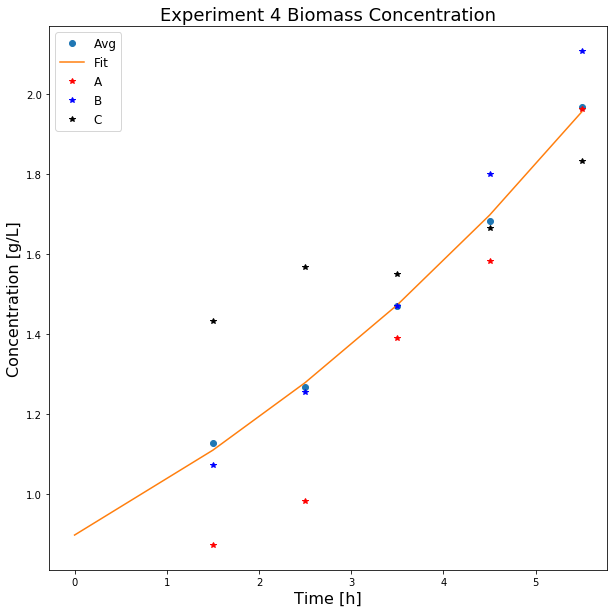

In [13]:
plt.figure(figsize=(10,10))

plt.title('Experiment 4 Biomass Concentration', fontsize = 18)

plt.xlabel('Time [h]', fontsize = 16)
plt.ylabel('Concentration [g/L]', fontsize = 16)

plt.plot(t1,Cx_4_avg,"o", label = "Avg")
plt.plot(t2_array,Cx_fit, label = "Fit")

plt.plot(t1, Cx_4_A,'*', color='red', label='A')
plt.plot(t1, Cx_4_B,'*', color='blue', label='B')
plt.plot(t1, Cx_4_C, '*', color='black', label='C')

plt.legend(loc='best', fontsize = 12)
plt.savefig('Mu_fit_E2.jpeg',dpi=1000)


In [14]:
Cx_fit[0]

0.8962327695386297

In [15]:
mu = mu_fit
mu

0.14190729019947726

# Fitting Gamma

In [16]:
t3_array = numpy.array([1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25])

In [17]:
T = 22 + 273.15
P = 101.325 #kPa

In [18]:
t_0 = 1.5
t_add1 = 3.0
t_add2 = 4.0
tmax=6

t_important = [0,t_0,t_add1, t_add2, tmax]
t_important

[0, 1.5, 3.0, 4.0, 6]

In [19]:
def response_fun(C):
    
    Cx, Ce, Cs = C[0],C[1], C[2]
    
    mu1=mu*Cs/(Km+Cs)
    theta1=theta
             
    S = numpy.matrix([[-1,1+alpha,1,0,0],
                      [ 0,0,-1,1,1.5],
                      [  0,beta,0,-1/3,0],
                      [ 0,-gamma,-1/3,0,1],
                      [ 0,1,0,0,0]])

    C = numpy.matrix([0, 0, 0, theta1, mu1]).T
    r = numpy.linalg.solve(S, C) 
        
    
    return [mu,        # biomass
            r[4,0],    # ethanol   
            r[0, 0]]    

In [20]:
def ferm_eq(t,C):
    Cx, Ce, Cs = C[0],C[1], C[2]   
    r=response_fun([Cx, Ce, Cs])
    
    return [r[0]*Cx,
            r[1]*Cx,
            r[2]*Cx]   

In [21]:
error = 1000
gamma_span = numpy.arange(0,2,0.001)

for gamma in gamma_span:
    
    squares = 0
    
    #Initial Concentrations at T=1.5
    Cx0 = Cx_fit[0]/24.6  #Initial Biomass Concentration g/L
    Ce0=0 #Non zero but low Ethanol Concentration
    Cg0=(25*2)/30 #Glucose as initially added
    Co=[Cx0, Ce0, Cg0]
    
    tspan = [0,6]

    C_sol=numpy.array([[],[],[]])
    t_sol=numpy.array([])
    
    for index,time in enumerate(t_important):

        if index==0:
            pass

        else:
            t_span=[t_important[index-1],time]
            teval=numpy.arange(t_important[index-1],time+0.5,0.5)
#             print (teval)

            C = scipy.integrate.solve_ivp(ferm_eq, t_span, Co, t_eval=teval)
#             print (C.y)

            C_sol=numpy.concatenate((C_sol,C.y),axis=1)

            Cx0 = C.y[0,-1]
            Ce0 = C.y[1,-1]
            Cg0 = C.y[2,-1]+((5*2)/30)
            Co=[Cx0, Ce0, Cg0]

            t_sol=numpy.concatenate((t_sol,teval))
            
            
            
    C_x_unique = numpy.array(uniquify(C_sol[0]))
    
#     Cx_u_2 = bio(t3_array,mu,Cx_fit[0])
    
    rco2_fit = []
    
    print (C_x_unique*24.6, gamma, Cx0)
    
    for index,value in enumerate(rco2_4_avg):
        
        rates = response_fun((C_sol[0][index], C_sol[1][index], C_sol[2][index]))

        rx, re, rs = rates

    
        fitted_rco2 = (0.5*re+alpha*rx)*(1/60)*8.314*(T+273)*1000/P*(C_x_unique[index]*24.6)/24.6*0.5

        squares+=(fitted_rco2-value)**2

        rco2_fit.append(fitted_rco2)
            
    if squares<error:
            
        gamma_acc=gamma
        error=squares
        rco2_fit_acc=rco2_fit

gamma_acc, mu

[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.0 0.08536169660485954
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.001 0.08536169660457199
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.002 0.08536169660428587
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.003 0.08536169660400113
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.004 0.08536169660371795
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.

[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.053 0.08536169659140676
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.054 0.08536169659118417
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.055 0.08536169659096271
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.056 0.08536169659074222
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.057 0.08536169659052278
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 

[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.107 0.08536169658072525
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.108 0.08536169658055057
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.109 0.08536169658037665
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.11 0.08536169658020343
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.111 0.08536169658003101
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2

 2.09989774] 0.168 0.08536169657131548
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.169 0.08536169657118023
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.17 0.08536169657104549
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.171 0.08536169657091132
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.17200000000000001 0.08536169657077762
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.17300000000000001 0.08536169657064453
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1

 2.09989774] 0.221 0.08536169656484172
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.222 0.0853616965647321
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.223 0.08536169656462295
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.224 0.08536169656451419
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.225 0.0853616965644058
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.226 0.08536169656429787
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.581026

 2.09989774] 0.28200000000000003 0.08536169655886801
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.28300000000000003 0.08536169655878108
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.28400000000000003 0.0853616965586945
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.28500000000000003 0.08536169655860823
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.28600000000000003 0.0853616965585223
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.28700000000000003 0.08536169655843667
[0.89623277 0.

[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.338 0.08536169655446489
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.339 0.08536169655439418
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.34 0.08536169655432378
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.341 0.08536169655425359
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.342 0.0853616965541837
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.

 2.09989774] 0.389 0.08536169655116753
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.39 0.08536169655110872
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.391 0.08536169655105016
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.392 0.08536169655099178
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.393 0.08536169655093359
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.394 0.0853616965508757
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.581026

 2.09989774] 0.444 0.08536169654822798
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.445 0.0853616965481797
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.446 0.0853616965481316
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.447 0.08536169654808365
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.448 0.08536169654803591
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.449 0.08536169654798831
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.581026

 2.09989774] 0.497 0.08536169654589316
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.498 0.08536169654585325
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.499 0.08536169654581345
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.5 0.08536169654577379
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.501 0.08536169654573429
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 0.502 0.08536169654569496
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.581026

[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.551 0.08536169654393026
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.552 0.08536169654389743
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.553 0.08536169654386466
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.554 0.0853616965438321
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.555 0.08536169654379959
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036443 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2

 2.09989773] 0.602 0.08536169654239964
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.603 0.08536169654237245
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.604 0.08536169654234534
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.605 0.0853616965423183
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.606 0.08536169654229137
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.607 0.08536169654226461
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102

 2.09989773] 0.671 0.0853616965407446
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.672 0.08536169654072373
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.673 0.08536169654070291
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.674 0.08536169654068221
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.675 0.08536169654066154
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.676 0.08536169654064096
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102

 2.09989773] 0.724 0.08536169653974561
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.725 0.08536169653972876
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.726 0.08536169653971205
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.727 0.08536169653969528
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.728 0.08536169653967869
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.729 0.08536169653966214
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.5810

[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.783 0.08536169653886662
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.784 0.08536169653885357
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.785 0.08536169653884061
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.786 0.0853616965388278
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.787 0.08536169653881497
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2

 2.09989773] 0.843 0.085361696538187
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.844 0.08536169653817728
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.845 0.0853616965381676
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.846 0.08536169653815807
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.847 0.08536169653814854
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.848 0.08536169653813905
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.5810260

[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.902 0.08536169653769791
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.903 0.08536169653769105
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.904 0.08536169653768416
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.905 0.08536169653767733
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.906 0.0853616965376705
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2

 2.09989773] 0.963 0.08536169653735184
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.964 0.08536169653734742
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.965 0.08536169653734295
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.966 0.08536169653733859
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.967 0.08536169653733426
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 0.968 0.08536169653732992
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.5810

 2.09989773] 1.025 0.0853616965371424
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.026 0.08536169653714003
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.027 0.08536169653713774
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.028 0.08536169653713548
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.029 0.08536169653713328
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.03 0.08536169653713108
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.581026

 2.09989773] 1.08 0.08536169653706001
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.081 0.08536169653705934
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.082 0.08536169653705868
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.083 0.0853616965370581
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.084 0.08536169653705747
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.085 0.08536169653705686
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.581026

 2.09989773] 1.1300000000000001 0.08536169653705884
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.131 0.0853616965370595
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.1320000000000001 0.08536169653706016
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.133 0.08536169653706081
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.1340000000000001 0.08536169653706152
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.135 0.08536169653706228
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.

 2.09989773] 1.184 0.08536169653712701
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.185 0.08536169653712894
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.186 0.0853616965371308
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.187 0.08536169653713276
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.188 0.08536169653713468
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.189 0.08536169653713664
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102

 2.09989773] 1.24 0.08536169653726489
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.241 0.08536169653726791
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.242 0.085361696537271
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.243 0.08536169653727402
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.244 0.08536169653727713
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.245 0.08536169653728022
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.5810260

 2.09989773] 1.306 0.085361696537504
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.307 0.08536169653750826
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.308 0.08536169653751242
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.309 0.08536169653751667
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.31 0.08536169653752095
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.311 0.08536169653752523
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.5810260

 2.09989773] 1.357 0.08536169653773862
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.358 0.08536169653774359
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.359 0.08536169653774862
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.36 0.08536169653775362
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.361 0.08536169653775862
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.362 0.08536169653776375
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102

 2.09989773] 1.408 0.08536169653801139
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.409 0.08536169653801712
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.41 0.08536169653802285
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.411 0.08536169653802858
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.412 0.08536169653803426
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.413 0.08536169653804004
[0.89623277 0.96213408 1.0328812  1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102

 2.09989773] 1.461 0.08536169653833095
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.462 0.08536169653833728
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.463 0.08536169653834359
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.464 0.08536169653835006
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.465 0.0853616965383564
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.466 0.08536169653836279
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102

 2.09989773] 1.514 0.0853616965386832
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.5150000000000001 0.08536169653869004
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.516 0.08536169653869706
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.5170000000000001 0.08536169653870397
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.518 0.08536169653871098
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.5190000000000001 0.08536169653871796
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.

 2.09989773] 1.576 0.08536169653913184
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.577 0.08536169653913939
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.578 0.08536169653914694
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.579 0.08536169653915444
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.58 0.08536169653916206
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.581 0.08536169653916961
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102

 2.09989773] 1.637 0.08536169653960711
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.6380000000000001 0.08536169653961516
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.639 0.08536169653962321
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.6400000000000001 0.08536169653963124
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.641 0.08536169653963935
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.6420000000000001 0.08536169653964742
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1

 2.09989773] 1.697 0.08536169654010316
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.698 0.08536169654011162
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.699 0.0853616965401201
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.7 0.08536169654012865
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.701 0.0853616965401371
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.702 0.08536169654014565
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608

 2.09989773] 1.748 0.0853616965405444
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.749 0.08536169654055319
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.75 0.08536169654056201
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.7510000000000001 0.08536169654057084
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.752 0.08536169654057965
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.7530000000000001 0.0853616965405885
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.371

 2.09989773] 1.8 0.08536169654101061
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.801 0.08536169654101974
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.802 0.08536169654102882
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.803 0.085361696541038
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.804 0.0853616965410471
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.805 0.08536169654105624
[0.89623277 0.96213408 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 

 2.09989773] 1.855 0.08536169654421927
[0.89623277 0.96213407 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.856 0.08536169654430913
[0.89623277 0.96213407 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.857 0.08536169654439921
[0.89623277 0.96213407 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.858 0.08536169654448933
[0.89623277 0.96213407 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.859 0.08536169654457965
[0.89623277 0.96213407 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989773] 1.86 0.08536169654467012
[0.89623277 0.96213407 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102

 2.09989774] 1.9120000000000001 0.08536169654954975
[0.89623277 0.96213407 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 1.913 0.0853616965496469
[0.89623277 0.96213407 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 1.9140000000000001 0.0853616965497441
[0.89623277 0.96213407 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 1.915 0.08536169654984142
[0.89623277 0.96213407 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 1.9160000000000001 0.08536169654993889
[0.89623277 0.96213407 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 1.917 0.08536169655003652
[0.89623277 0.96213407 1.03288121 1.10883046 1.19036442 1.2

 2.09989774] 1.966 0.08536169655495708
[0.89623277 0.96213407 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 1.967 0.08536169655506025
[0.89623277 0.96213407 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 1.968 0.08536169655516347
[0.89623277 0.96213407 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 1.969 0.08536169655526685
[0.89623277 0.96213407 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 1.97 0.0853616965553703
[0.89623277 0.96213407 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.58102608 1.69728133 1.82208487 1.95606539
 2.09989774] 1.971 0.0853616965554739
[0.89623277 0.96213407 1.03288121 1.10883046 1.19036442 1.27789363
 1.37185901 1.47273382 1.5810260

(1.2730000000000001, 0.14190729019947726)

In [22]:
gamma_acc, mu, error

(1.2730000000000001, 0.14190729019947726, 10.247643382960469)

In [23]:
rco2_fit = rco2_fit_acc
rco2_fit

[3.6661315875015017,
 3.9357077883994966,
 4.225106362468521,
 4.535784822395175,
 4.8693113014990015,
 5.22735896061152,
 5.6117345096571345,
 6.024373845374216,
 6.467357915227402]

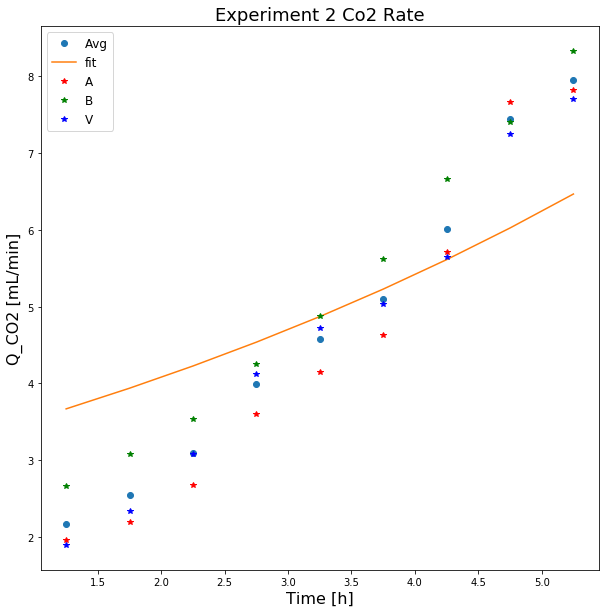

In [24]:
plt.figure(figsize=(10,10))

plt.title('Experiment 2 Co2 Rate', fontsize = 18)

plt.xlabel('Time [h]', fontsize = 16)
plt.ylabel('Q_CO2 [mL/min]', fontsize = 16)

plt.plot(t2,rco2_4_avg,"o", label='Avg')

plt.plot(t3_array,rco2_fit, label='fit')

plt.plot(t2,rco2_4_A,"*r", label='A')
plt.plot(t2,rco2_4_B,"*g", label='B')
plt.plot(t2,rco2_4_C,"*b", label='V')

plt.legend(loc='best', fontsize = 12)

plt.savefig('Rco2_E2.jpeg',dpi=1000)

# Plot Theory To Data

In [25]:
gamma = gamma_acc
# gamma = 1.45
mu, gamma

(0.14190729019947726, 1.2730000000000001)

In [26]:
#Initial Concentrations at T=1.5

Cx0 = Cx_fit[0]/24.6  #Initial Biomass Concentration g/L
print (Cx0, "g/L")

Ce0=0.1 #Non zero but low Ethanol Concentration

Cg0=(25*2)/30 #Glucose as initially added

Co=[Cx0, Ce0, Cg0]

0.03643222640400934 g/L


In [27]:
t_0 = 1.5
t_add1 = 3.0
t_add2 = 4.0
tmax=6

t_important = [0,t_0,t_add1, t_add2, tmax]
t_important

[0, 1.5, 3.0, 4.0, 6]

In [28]:
C_sol=numpy.array([[],[],[]])
t_sol=numpy.array([])

for index,time in enumerate(t_important):
#     print (index,time)    
    
    if index==0:
        pass
    
    else:
        t_span=[t_important[index-1],time]
#         print (t_span)
        teval=numpy.arange(t_important[index-1],time+0.5,0.5)
        print (teval)
        C = scipy.integrate.solve_ivp(ferm_eq, t_span, Co, t_eval=teval)
#         print (C_sol,C.y)
        print (C.y)
        C_sol=numpy.concatenate((C_sol,C.y),axis=1)
        
#         print (Co, "Co pre")
        Cx0 = C.y[0,-1]
        Ce0 = C.y[1,-1]
        Cg0 = C.y[2,-1]+((5*2)/30)
        Co=[Cx0, Ce0, Cg0]
        t_sol=numpy.concatenate((t_sol,teval))
#         print (Co, "Co post")
    
print(C_sol, t_sol)

#There is a duplication of times, which is intentional to allow for plotting of the discontinous glucose concentrations

[0.  0.5 1.  1.5]
[[0.03643223 0.03911114 0.04198704 0.04507441]
 [0.1        0.10924406 0.11916783 0.12982132]
 [1.66666667 1.68428321 1.70319511 1.72349762]]
[1.5 2.  2.5 3. ]
[[0.04507441 0.0483888  0.0519469  0.05576663]
 [0.12982132 0.14125819 0.15353602 0.16671666]
 [2.05683096 2.07862639 2.10202445 2.127143  ]]
[3.  3.5 4. ]
[[0.05576663 0.05986723 0.06426935]
 [0.16671666 0.1808665  0.1960568 ]
 [2.46047633 2.48744192 2.51639031]]
[4.  4.5 5.  5.5 6. ]
[[0.06426935 0.06899518 0.07406849 0.07951485 0.0853617 ]
 [0.1960568  0.21236409 0.22987045 0.24866408 0.26883964]
 [2.84972365 2.88080071 2.91416288 2.9499782  2.9884271 ]]
[[0.03643223 0.03911114 0.04198704 0.04507441 0.04507441 0.0483888
  0.0519469  0.05576663 0.05576663 0.05986723 0.06426935 0.06426935
  0.06899518 0.07406849 0.07951485 0.0853617 ]
 [0.1        0.10924406 0.11916783 0.12982132 0.12982132 0.14125819
  0.15353602 0.16671666 0.16671666 0.1808665  0.1960568  0.1960568
  0.21236409 0.22987045 0.24866408 0.268839

In [29]:
Cx=C_sol[0]*24.6             
print (Cx)
Ce=C_sol[1]*23

Cx_u = uniquify(numpy.array(Cx))
Cx_u

[0.89623277 0.96213412 1.03288123 1.10883047 1.10883047 1.19036446
 1.27789367 1.37185903 1.37185903 1.47273384 1.5810261  1.5810261
 1.69728139 1.82208496 1.95606542 2.09989778]


[0.8962327695386297,
 0.9621341215311564,
 1.0328812294618113,
 1.1088304738614696,
 1.1903644565829001,
 1.2778936700221912,
 1.3718590320661377,
 1.472733840730353,
 1.5810261031160038,
 1.697281392432701,
 1.822084960131185,
 1.9560654243513034,
 2.099897781362704]

In [30]:
# Cx_plot = numpy.concatenate((numpy.array([Cx_fit[0]]),Cx))
# t_sol_plot = numpy.concatenate((numpy.array([0]),t_sol))

In [31]:
Cx, t_sol

(array([0.89623277, 0.96213412, 1.03288123, 1.10883047, 1.10883047,
        1.19036446, 1.27789367, 1.37185903, 1.37185903, 1.47273384,
        1.5810261 , 1.5810261 , 1.69728139, 1.82208496, 1.95606542,
        2.09989778]),
 array([0. , 0.5, 1. , 1.5, 1.5, 2. , 2.5, 3. , 3. , 3.5, 4. , 4. , 4.5,
        5. , 5.5, 6. ]))

In [32]:
# Cx_plot, t_sol_plot

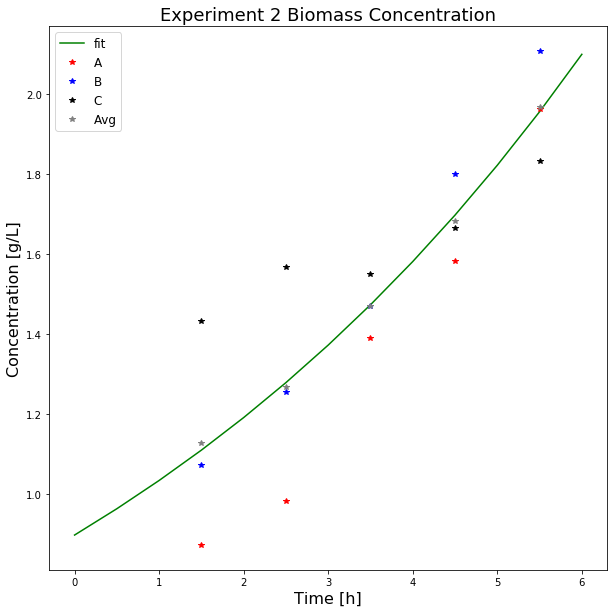

In [33]:
plt.figure(figsize=(10,10))

plt.title('Experiment 2 Biomass Concentration', fontsize = 18)

plt.xlabel('Time [h]', fontsize = 16)
plt.ylabel('Concentration [g/L]', fontsize = 16)

plt.plot(t_sol, Cx, "-",color='green',label='fit')
plt.plot(t1, Cx_4_A,'*', color='red', label='A')
plt.plot(t1, Cx_4_B,'*', color='blue', label='B')
plt.plot(t1, Cx_4_C, '*', color='black', label='C')
plt.plot(t1, Cx_4_avg, '*', color='grey', label='Avg')

plt.legend(loc='best', fontsize = 12)

plt.savefig('Cx_E2.jpeg',dpi=1000)

plt.show()



In [34]:
mu, gamma

(0.14190729019947726, 1.2730000000000001)